In [27]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

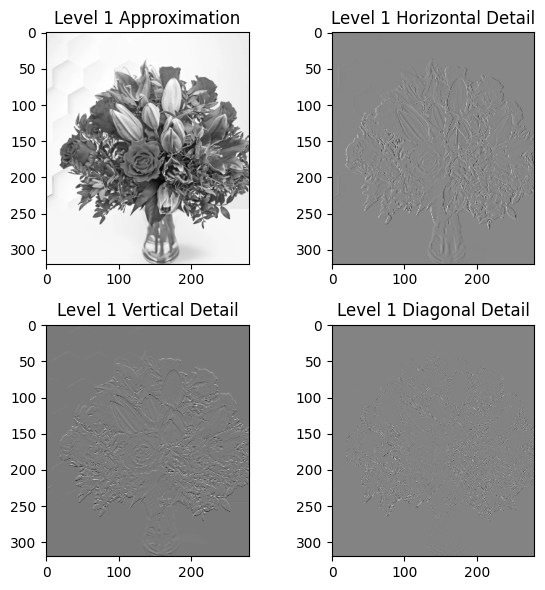

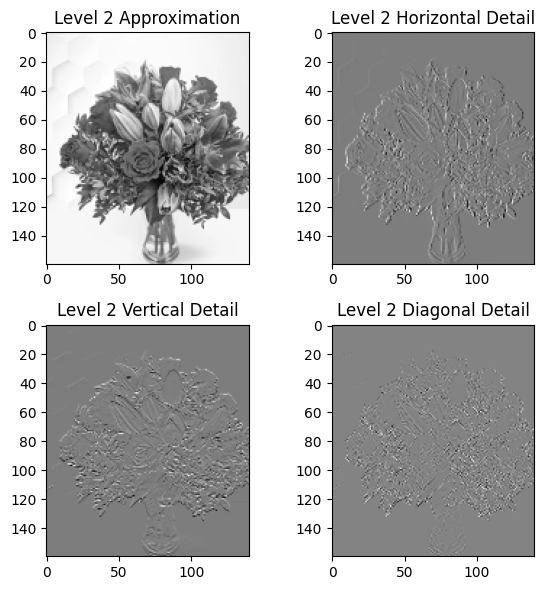

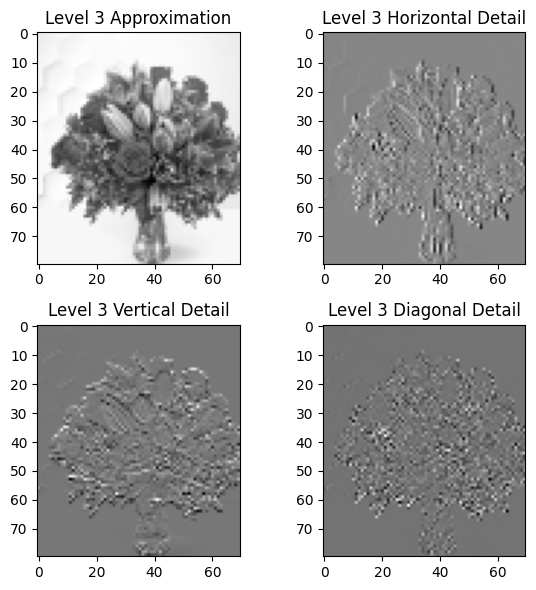

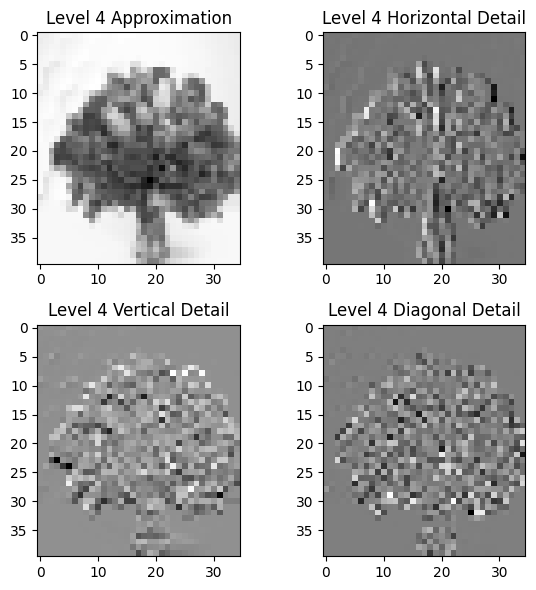

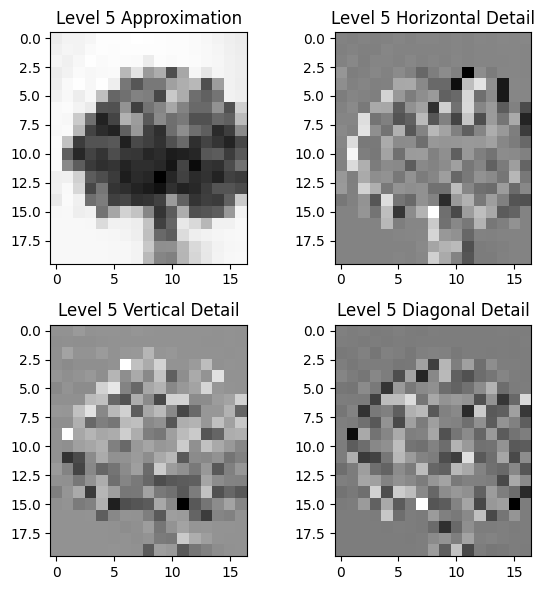

In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def haar_1D(input: np.array) -> np.array:
    N = len(input)
    if N % 2 != 0:
        input = input[:-1]
        N -= 1
        
    result = np.zeros(N, dtype=np.float32)
    for i in range(0, N, 2):
        result[i // 2] = (input[i] + input[i + 1]) / 2
        result[N // 2 + i // 2] = (input[i] - input[i + 1]) / 2
    return result

def haar_2d(input: np.array) -> np.array:
    row_transformed = np.apply_along_axis(func1d=haar_1D, axis=1, arr=input)
    final = np.apply_along_axis(func1d=haar_1D, axis=0, arr=row_transformed)
    return final

def dwt_multilevel(image, levels):
    coeffs = []
    current_image = image.astype(np.float32)
    for level in range(levels):
        transformed = haar_2d(current_image)
        
        h, w = transformed.shape
        approximation = transformed[:h//2, :w//2]
        horizontal = transformed[:h//2, w//2:]
        vertical = transformed[h//2:, :w//2]
        diagonal = transformed[h//2:, w//2:]
        
        coeffs.append((approximation, horizontal, vertical, diagonal))
        
        current_image = approximation
    return coeffs

flower = cv2.imread("data/flower.png", cv2.IMREAD_GRAYSCALE)
flower1 = flower[:16*40, :16*35]

coefficients = dwt_multilevel(flower1, 5)
levels = 5
import pywt as pt

for level, (approx, horiz, vert, diag) in enumerate(coefficients):
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))
    
    axes[0, 0].imshow(approx, cmap='gray')
    axes[0, 0].set_title(f'Level {level+1} Approximation')
    axes[0, 0].axis('on')
    
    axes[0, 1].imshow(horiz, cmap='gray')
    axes[0, 1].set_title(f'Level {level+1} Horizontal Detail')
    axes[0, 1].axis('on')

    axes[1, 0].imshow(vert, cmap='gray')
    axes[1, 0].set_title(f'Level {level+1} Vertical Detail')
    axes[1, 0].axis('on')
    
    axes[1, 1].imshow(diag, cmap='gray')
    axes[1, 1].set_title(f'Level {level+1} Diagonal Detail')
    axes[1, 1].axis('on')
    
    plt.tight_layout()
    
    plt.savefig(f'level_{level+1}_coefficients.png', bbox_inches='tight', dpi=300)
    
    plt.show()



array([[ 2.76812000e+05,  1.31013696e+03, -3.56076221e+03, ...,
         7.73255920e+00,  3.13941650e+01,  5.18084717e+00],
       [ 2.76820000e+05,  1.31440576e+03, -3.56648389e+03, ...,
         7.87161255e+00,  3.14637451e+01,  5.20654297e+00],
       [ 2.76790000e+05,  1.28623621e+03, -3.58952637e+03, ...,
         5.78169250e+00,  2.95906982e+01,  4.10437012e+00],
       ...,
       [ 2.63502000e+05,  3.23946216e+03,  1.07128672e+04, ...,
        -3.81687012e+01, -2.93627930e+01,  6.12304688e+01],
       [ 2.64932000e+05,  2.86423462e+03,  9.56298438e+03, ...,
         2.46237793e+01, -3.66865234e+01,  9.95263672e+00],
       [ 2.66130000e+05,  2.54780127e+03,  8.54808105e+03, ...,
         1.13002930e+01, -1.20078125e+01,  2.81945801e+00]], dtype=float32)

In [29]:
#########
#***************************************************************************
#***********************Part B**************************
flower = cv2.imread("data/flower.png", cv2.IMREAD_GRAYSCALE)
flower1 = flower[:16*40, :16*35].astype(np.float32)
variance = 0.1
noise = np.random.normal(0, np.sqrt(variance), size=flower1.shape)
noisy_image = flower1 + noise


In [30]:
coeffs_original = pt.dwt2(flower1,'haar')  # Change 'haar' to your desired wavelet
coeffs_noisy =pt.dwt2(noisy_image,'haar')

In [31]:
coeff2 = haar_2d(flower1)
coeffnoise = haar_2d(noisy_image)

In [32]:
dwt_diff = (coeffs_noisy[0] - coeffs_original[0], 
            coeffs_noisy[1][0] - coeffs_original[1][0],
            coeffs_noisy[1][1] - coeffs_original[1][1])

In [33]:
flattened_noise = np.concatenate([dwt_diff[0].flatten(), 
                                   dwt_diff[1].flatten(), 
                                   dwt_diff[2].flatten()])


Mean of the noise: 0.000635244747720621
Variance of the noise: 0.10003087172633475


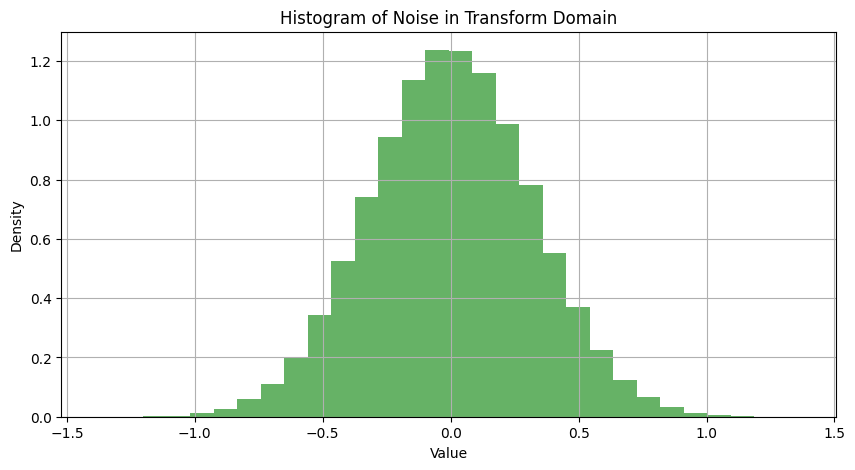

In [34]:
plt.figure(figsize=(10, 5))
plt.hist(flattened_noise, bins=30, density=True, alpha=0.6, color='g')
plt.title('Histogram of Noise in Transform Domain')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid()
mean_noise = np.mean(flattened_noise)
variance_noise = np.var(flattened_noise)

print(f'Mean of the noise: {mean_noise}')
print(f'Variance of the noise: {variance_noise}')

plt.show()

In [35]:
def soft_threshold(d, t):
    """Apply soft thresholding to a coefficient."""
    if d < -t:
        return d + t
    elif -t <= d <= t:
        return 0
    else:
        return d - t

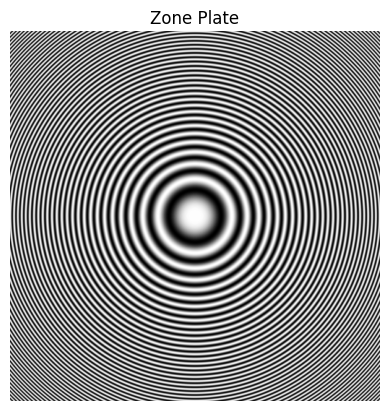

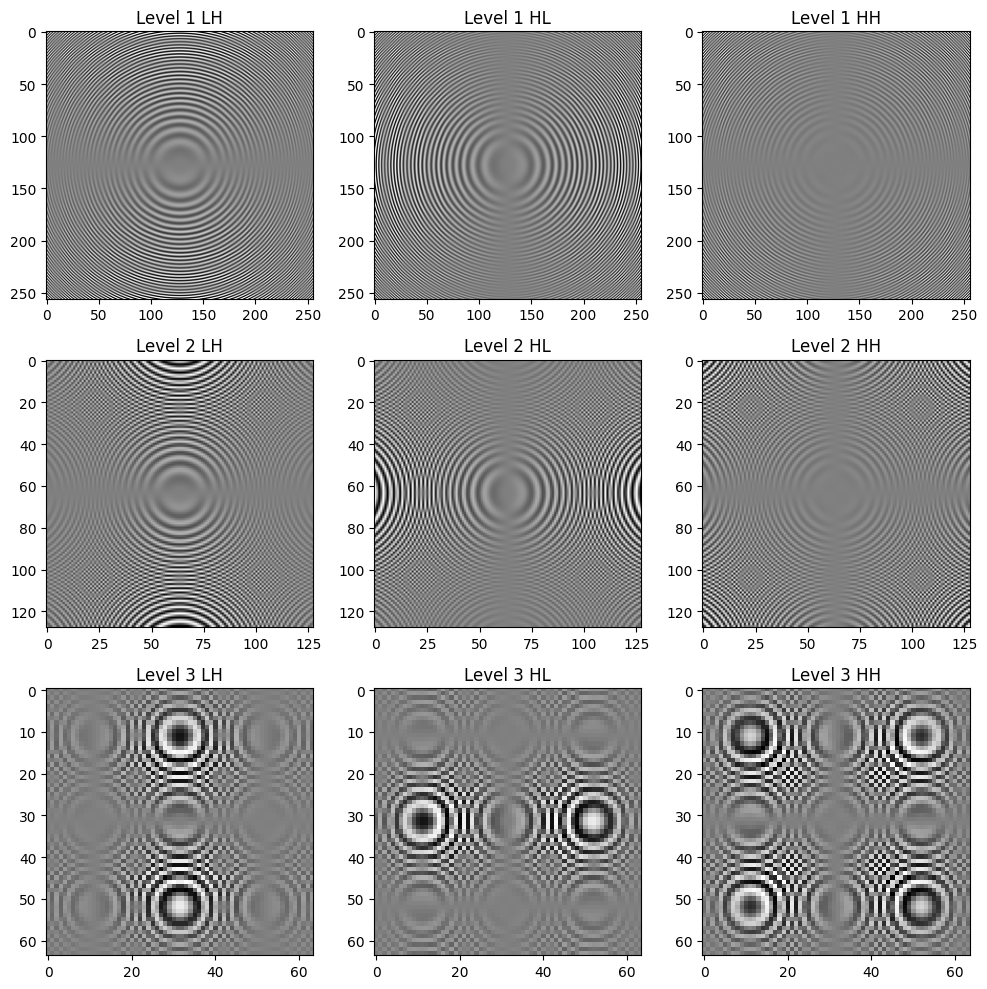

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import cv2

# Create a zone plate image
def generate_zone_plate(size):
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    X, Y = np.meshgrid(x, y)
    radius = np.sqrt(X**2 + Y**2)
    zone_plate = 0.5 * (1 + np.cos(50 * np.pi * radius**2))
    return (zone_plate * 255).astype(np.uint8)

# Generate and display the zone plate
size = 512
zone_plate_image = generate_zone_plate(size)
plt.imshow(zone_plate_image, cmap='gray')
plt.title("Zone Plate")
plt.axis('off')
plt.show()

# Apply the 2D Haar wavelet transform on the zone plate
def dwt2D(image, levels=1):
    coeffs_list = []
    current_coeffs = image
    for _ in range(levels):
        current_coeffs = pywt.dwt2(current_coeffs, 'haar')
        LL, (LH, HL, HH) = current_coeffs
        coeffs_list.append((LH, HL, HH))
        current_coeffs = LL  # Update to the next LL component
    return coeffs_list

# Set levels for DWT
levels = 3  # Example level
coeffs_list = dwt2D(zone_plate_image, levels)

# Function to plot DWT coefficients
def plot_coefficients(coeffs_list, levels):
    plt.figure(figsize=(10, 10))
    for i in range(levels):
        LH, HL, HH = coeffs_list[i]
        plt.subplot(levels, 3, 3*i + 1)
        plt.imshow(LH, cmap='gray')
        plt.title(f'Level {i+1} LH')
        plt.subplot(levels, 3, 3*i + 2)
        plt.imshow(HL, cmap='gray')
        plt.title(f'Level {i+1} HL')
        plt.subplot(levels, 3, 3*i + 3)
        plt.imshow(HH, cmap='gray')
        plt.title(f'Level {i+1} HH')
        plt.savefig(f"mm{i}.png")

    plt.tight_layout()

    plt.show()

# Plot the coefficients to verify detail coefficients
plot_coefficients(coeffs_list, levels)
